In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import time

In [2]:
!wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
import colab_github
colab_github.github_auth(persistent_key=True)

# method to import git data into colab taken from:
# https://github.com/tsunrise/colab-github

Mounted at /content/drive/
Looks that a private key is already created. If you have already push it to github, no action required.
 Otherwise, Please go to https://github.com/settings/ssh/new to upload the following key: 
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIPNHesHoZ8yifpxV8MpOj9wzeMMzniVoRcF992tjnH5Y root@b3bd0b87503a

Please use SSH method to clone repo.


In [3]:
!git clone git@github.com:jonq-q/Comp432-GroupQ.git

Cloning into 'Comp432-GroupQ'...
remote: Enumerating objects: 18084, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 18084 (delta 10), reused 0 (delta 0), pack-reused 18054
Receiving objects: 100% (18084/18084), 1.14 GiB | 16.98 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Updating files: 100% (18018/18018), done.


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!ls /content/Comp432-GroupQ/Dataset\ 2

'Prostate Cancer'


In [5]:
dataset = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 1/Colorectal Cancer /", transforms.Compose([
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

train_set, test_set = torch.utils.data.random_split(dataset,[0.7,0.3])                # splits dataset into specified ratios
train_loader = DataLoader(train_set,shuffle=True,batch_size=32, num_workers=0)         # create train loader
test_loader = DataLoader(test_set,batch_size=32, num_workers=0)  # create test loader

In [11]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

if torch.cuda.is_available():
    model = model.to('cuda')

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [12]:
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    current_loss = 0.0
    correct = 0
    total = 0
    round = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        y_pred = model(inputs)
        l = loss(y_pred, labels)
        l.backward()
        optimizer.step()

        current_loss += l.item()
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time for one epoch: {elapsed_time} seconds")
    train_accuracy = 100 * correct / total
    train_loss = current_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')

Training time for one epoch: 38.38173007965088 seconds
Epoch 1/20, Loss: 1.5096, Accuracy: 71.55%
Training time for one epoch: 38.40942716598511 seconds
Epoch 2/20, Loss: 0.4564, Accuracy: 83.12%
Training time for one epoch: 39.00608730316162 seconds
Epoch 3/20, Loss: 0.3799, Accuracy: 85.07%
Training time for one epoch: 38.34397315979004 seconds
Epoch 4/20, Loss: 0.3443, Accuracy: 86.93%
Training time for one epoch: 38.62550687789917 seconds
Epoch 5/20, Loss: 0.3098, Accuracy: 88.38%
Training time for one epoch: 38.812801122665405 seconds
Epoch 6/20, Loss: 0.2465, Accuracy: 90.62%
Training time for one epoch: 38.421759366989136 seconds
Epoch 7/20, Loss: 0.2444, Accuracy: 90.81%
Training time for one epoch: 38.67385721206665 seconds
Epoch 8/20, Loss: 0.2359, Accuracy: 91.12%
Training time for one epoch: 39.26721692085266 seconds
Epoch 9/20, Loss: 0.2247, Accuracy: 92.55%
Training time for one epoch: 39.24711346626282 seconds
Epoch 10/20, Loss: 0.1988, Accuracy: 92.24%
Training time for

In [24]:
pip install thop

In [27]:
from thop import profile

# Input tensor (batch size, channels, height, width)
input_tensor = torch.randn(1, 3, 224, 224).to('cuda')

flops, params = profile(model, inputs=(input_tensor,))

print(f"Number of FLOPs: {flops / 1e9} G FLOPs")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Number of FLOPs: 1.824033792 G FLOPs


In [ ]:
val_loss = []

with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in test_loader:
                image = image.to('cuda')
                label = label.to('cuda')
                optimizer.zero_grad()
                y_pred = model.forward(image)
                l = loss(y_pred,label)
                running_loss += l.item()

                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()

          epoch_score = running_score/len(test_loader.dataset)
          epoch_loss = running_loss/len(test_loader.dataset)
          val_loss.append(epoch_loss)
          print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

          all_predictions = []
          true_labels = []
          for inputs, labels in test_loader:
              inputs, labels = inputs.to('cuda'), labels.to('cuda')
              outputs = model.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              all_predictions.extend(predicted.cpu().numpy())
              true_labels.extend(labels.cpu().numpy())

classification_rep = classification_report(true_labels, all_predictions, target_names=dataset.classes)
print(classification_rep)

Validation loss: 0.006688712824963861, accuracy: 0.9177777777777778
              precision    recall  f1-score   support

         MUS       0.97      0.81      0.88       660
        NORM       0.94      0.99      0.96       581
         STR       0.84      0.96      0.90       559

    accuracy                           0.91      1800
   macro avg       0.92      0.92      0.91      1800
weighted avg       0.92      0.91      0.91      1800



**Save trained model from dataset 1**

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/TrainedModel')

In [4]:
pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
pretrained_model.load_state_dict(torch.load('/content/drive/My Drive/Comp 432/TrainedModel', map_location=torch.device('cuda')))

#pretrained_model.load_state_dict(torch.load('/content/drive/My Drive/TrainedModel', map_location=torch.device('cuda')))

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
pretrained_model.to('cuda')

with torch.no_grad():
          pretrained_model.eval()
          all_predictions = []
          true_labels = []
          for inputs, labels in test_loader:
              inputs, labels = inputs.to('cuda'), labels.to('cuda')
              outputs = pretrained_model.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              all_predictions.extend(predicted.cpu().numpy())
              true_labels.extend(labels.cpu().numpy())

classification_rep = classification_report(true_labels, all_predictions, target_names=dataset.classes)
print(classification_rep)

              precision    recall  f1-score   support

         MUS       0.97      0.80      0.88       660
        NORM       0.94      0.99      0.96       581
         STR       0.83      0.96      0.89       559

    accuracy                           0.91      1800
   macro avg       0.91      0.92      0.91      1800
weighted avg       0.92      0.91      0.91      1800



In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

confMatrix = multilabel_confusion_matrix(true_labels, all_predictions, labels=[0, 1, 2])
print(confMatrix)

[[[1124   16]
  [ 130  530]]

 [[1182   37]
  [   6  575]]

 [[1134  107]
  [  24  535]]]


In [ ]:
pretrained_model

In [7]:
device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")

In [ ]:
from typing_extensions import Self
#print(list(pretrained_model.children()))
features=list(pretrained_model.children())[:-1] #only remove fc
model_out=nn.Sequential(*features).to(device)
def for_feature(loader):
  data_tmp=[]
  label_tmp=[]

  with torch.no_grad():
      for img,label in loader:
        img=img.to(device)

        output1=model_out(img)

        data_tmp.append(output1.cpu().numpy())
        label_tmp.append(label.cpu().numpy())

  return np.vstack(data_tmp), np.hstack(label_tmp)

In [ ]:
trained_feature, trained_label=for_feature(train_loader)

In [ ]:
trained_feature_n = trained_feature.reshape(4200,512)

In [ ]:
from scipy import stats
stats.describe(trained_label)

DescribeResult(nobs=4200, minmax=(0, 2), mean=1.024047619047619, variance=0.6617221220471995, skewness=-0.044032147322283735, kurtosis=-1.4871486083671512)

In [11]:
#T-SNE
from sklearn.manifold import TSNE
import plotly.express as px
#plot_matrix_grid(model.coef_[0].T.reshape(-1,224,224))

In [ ]:
tsne=TSNE(n_components=2, random_state=0, learning_rate='auto')
projections=tsne.fit_transform(trained_feature_n)
fig=px.scatter(projections[:,0], projections[:,1], color = trained_label, labels={"color":""})
fig.show()

In [ ]:
dataset1 = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 1/Colorectal Cancer ", transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

dataloader_sc = DataLoader(dataset1, batch_size=64, shuffle=True)

In [ ]:
features = list(pretrained_model.children())[:-1] #only remove fc
resnet_nohead = nn.Sequential(*features).to(device)
resnet_nohead = resnet_nohead.eval()

In [ ]:
all_features = []
all_labels = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

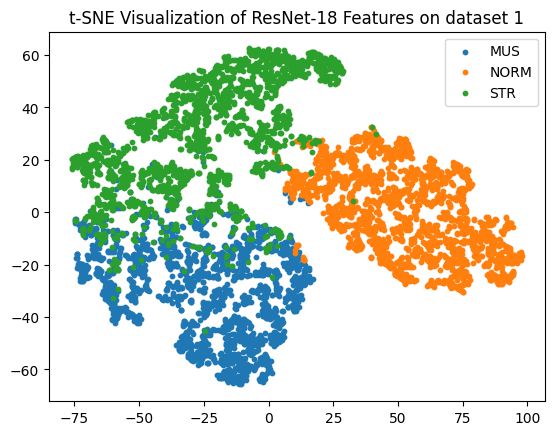

In [ ]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='MUS',s=10)
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='NORM',s=10)
plt.scatter(embedded_features[all_labels == 2, 0], embedded_features[all_labels == 2, 1], label='STR',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 1')
plt.legend()
plt.show()

In [5]:
#task 2 Pretrained ResNet18 applied to Dataset2 & 3
dataset2 = datasets.ImageFolder("/content/Comp432-GroupQ/Dataset 2/Prostate Cancer/", transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

dataloader_sc1 = DataLoader(dataset2, batch_size=64, shuffle=True)

In [8]:
features = list(pretrained_model.children())[:-1] #only remove fc
resnet_nohead = nn.Sequential(*features).to(device)
resnet_nohead = resnet_nohead.eval()

**Scenario 1: Task 1 on dataset 2**

In [9]:
all_features = []
all_labels = []

resnet_nohead.to(device)

with torch.no_grad():
    for images, labels in dataloader_sc1:
        images = images.to(device)
        labels = labels.to(device)
        features = resnet_nohead(images)
        features = features.squeeze().cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Concatenate features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [12]:
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

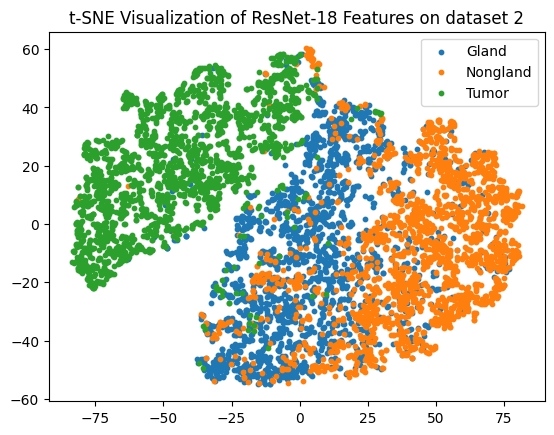

In [13]:
# Plot the t-SNE embeddings with different colors for each class
plt.scatter(embedded_features[all_labels == 0, 0], embedded_features[all_labels == 0, 1], label='Gland',s=10)
plt.scatter(embedded_features[all_labels == 1, 0], embedded_features[all_labels == 1, 1], label='Nongland',s=10)
plt.scatter(embedded_features[all_labels == 2, 0], embedded_features[all_labels == 2, 1], label='Tumor',s=10)

plt.title('t-SNE Visualization of ResNet-18 Features on dataset 2')
plt.legend()
plt.show()

In [14]:
def extract_features(model, dataloader):
    model.eval()
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            features = model(images)
            all_features.append(features.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.vstack(all_features), np.array(all_labels)

# Extract features from the dataset
features, labels = extract_features(resnet_nohead, dataloader_sc1)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Create k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Evaluate the model
accuracy = knn_classifier.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 89.44%


In [20]:
y_pred_knn = knn_classifier.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       596
           1       0.86      0.87      0.87       598
           2       0.99      0.96      0.97       606

    accuracy                           0.89      1800
   macro avg       0.90      0.89      0.89      1800
weighted avg       0.90      0.89      0.89      1800



In [21]:
from sklearn.metrics import multilabel_confusion_matrix

confMatrix_knn = multilabel_confusion_matrix(y_test, y_pred_knn)
print(confMatrix_knn)

[[[1107   97]
  [  91  505]]

 [[1117   85]
  [  75  523]]

 [[1186    8]
  [  24  582]]]


In [22]:
from sklearn import svm

svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)

# Evaluate the SVM model
y_pred_svm = svm_classifier.predict(X_test)

In [23]:
print("Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.85      0.86      0.86       596
           1       0.88      0.88      0.88       598
           2       0.98      0.97      0.98       606

    accuracy                           0.90      1800
   macro avg       0.90      0.90      0.90      1800
weighted avg       0.90      0.90      0.90      1800



In [25]:
confMatrix_svm = multilabel_confusion_matrix(y_test, y_pred_svm)
print(confMatrix_svm)

[[[1112   92]
  [  81  515]]

 [[1128   74]
  [  74  524]]

 [[1185    9]
  [  20  586]]]


In [ ]:
import torchvision.models as models

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG_16=models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.

